In [5]:
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
import uuid
from langgraph.store.memory import InMemoryStore

In [3]:

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

model = ChatOpenAI(model="gpt-4o", temperature=0)
model_with_structure = model.with_structured_output(MemoryCollection)

memory_collection = model_with_structure.invoke([HumanMessage("My name is Angelo. I like to fly.")])
memory_collection.memories

[Memory(content="User's name is Angelo."),
 Memory(content='User likes to fly.')]

In [4]:
memory_collection.memories[0].model_dump()

{'content': "User's name is Angelo."}

In [6]:
in_memory_store = InMemoryStore()

user_id = "1"
namespace_for_memory = (user_id, "memories")

key = str(uuid.uuid4())
value = memory_collection.memories[0].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

key = str(uuid.uuid4())
value = memory_collection.memories[1].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

In [7]:
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'value': {'content': "User's name is Angelo."}, 'key': '64a862c4-ac93-4a95-a840-7ab6925a3727', 'namespace': ['1', 'memories'], 'created_at': '2025-01-01T22:24:55.938636+00:00', 'updated_at': '2025-01-01T22:24:55.938638+00:00', 'score': None}
{'value': {'content': 'User likes to fly.'}, 'key': '9558e44b-67ee-4bb2-b5c1-c3daa7a178a7', 'namespace': ['1', 'memories'], 'created_at': '2025-01-01T22:24:55.938743+00:00', 'updated_at': '2025-01-01T22:24:55.938744+00:00', 'score': None}


# Updating collection schema

In [9]:
from trustcall import create_extractor
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

In [10]:
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

instruction = """Extract memories from the following conversation:"""
conversation = [HumanMessage(content="Hi, I'm Angelo"),
                AIMessage(content="Nice to meet you Angelo"),
                HumanMessage(content="This morning I had a nice meal. I ate Shakshuka.")]

result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [11]:
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_ACKUajbkqNzz4laSE0Q3ddai)
 Call ID: call_ACKUajbkqNzz4laSE0Q3ddai
  Args:
    content: Angelo had a nice meal this morning and ate Shakshuka.


In [12]:
for m in result["response_metadata"]:
    print(m)

{'id': 'call_ACKUajbkqNzz4laSE0Q3ddai'}


In [13]:
updated_conversation = [AIMessage(content="That's great, what did you do after?"),
                        HumanMessage(content="I flew to the moon and made a Tulpa."),
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about dogs chasing their tails")]

system_msg = """Update existing memories and acreate new ones based on the following conversation:"""

tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'Angelo had a nice meal this morning and ate Shakshuka.'})]

In [14]:
result = trustcall_extractor.invoke({"messages": updated_conversation,
                                     "existing": existing_memories})
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_mF1o26UtKwTtgKAFra7PAqQt)
 Call ID: call_mF1o26UtKwTtgKAFra7PAqQt
  Args:
    content: Angelo had a nice meal this morning and ate Shakshuka. After that, he flew to the moon and made a Tulpa. He was also thinking about dogs chasing their tails.
  Memory (call_ZplG0lepm3LUL7EulsxYo5o6)
 Call ID: call_ZplG0lepm3LUL7EulsxYo5o6
  Args:
    content: Angelo flew to the moon and made a Tulpa. He was also thinking about dogs chasing their tails.


In [15]:
for m in result["responses"]:
    print(m)

content='Angelo had a nice meal this morning and ate Shakshuka. After that, he flew to the moon and made a Tulpa. He was also thinking about dogs chasing their tails.'
content='Angelo flew to the moon and made a Tulpa. He was also thinking about dogs chasing their tails.'


In [16]:
for m in result["response_metadata"]:
    print(m)

{'id': 'call_mF1o26UtKwTtgKAFra7PAqQt', 'json_doc_id': '0'}
{'id': 'call_ZplG0lepm3LUL7EulsxYo5o6'}


# Chatbot with collection schema updating

In [20]:
from IPython.display import Image, display

import uuid

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore



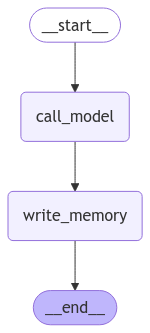

In [ ]:
model = ChatOpenAI(model="gpt-4o", temperature=0)

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. FOr example: User expressed interest in learning about the French.")

trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You are designed to be a companion to a user.
You have a long term memory which keeps track of information you learn about the user over time.
Current Memory (may include updated memories from this conversation):
{memory}"""

TRUSTCALL_INSTRUCTION = """Reflect on following interaction.
Use the provided tools to retain any necessary memories about the user.
Use parallel tool calling to handle updates and insertions simultaneously:"""

def call_model(state: MessagesState, config:RunnableConfig, store:BaseStore):
    """Load memories from the store and use them to personalize the chatbot's response."""
    user_id = config["configurable"]["user_id"]

    namespace = ("memories", user_id)
    memories = store.search(namespace)

    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])
    return {"messages": response}

def write_memory(state: MessagesState, config:RunnableConfig, store:BaseStore):
    """Reflect on the chat history and update the memory collection."""

    user_id = config["configurable"]["user_id"]
    namespace = ("memories", user_id)
    existing_items = store.search(namespace)

    tool_name = "Memory"
    existing_memories = ([(existing_items.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items else None)
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]))

    result = trustcall_extractor.invoke({"messages": updated_messages, "existing": existing_memories})

    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),)

builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

across_thread_memory = InMemoryStore()
within_thread_memory = MemorySaver()
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

input_messages = [HumanMessage(content="Hi, my name is Angelo.")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()



================================ Human Message =================================

Hi, my name is Angelo.
================================== Ai Message ==================================

Hi Angelo! It's great to meet you. How can I assist you today?


In [25]:
input_messages = [HumanMessage(content="I like to whip and naenae")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

I like to whip and naenae
================================== Ai Message ==================================

That's awesome! "Watch Me (Whip/Nae Nae)" is such a fun song to dance to. Do you enjoy dancing to other songs as well?


In [26]:
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'value': {'content': 'User likes to whip and naenae, indicating an interest in dancing.'}, 'key': '0ddafe23-aa26-439f-9054-b09db43481c6', 'namespace': ['memories', '1'], 'created_at': '2025-01-01T23:16:21.587989+00:00', 'updated_at': '2025-01-01T23:16:21.587989+00:00', 'score': None}


In [27]:
input_messages = [HumanMessage(content="I also haven't slept for two days!")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

I also haven't slept for two days!
================================== Ai Message ==================================

That sounds really tough. Lack of sleep can affect how you feel and function. Is there something specific keeping you up, or do you often have trouble sleeping?


AttributeError: 'list' object has no attribute 'key'